In [1]:
using CSV, StatsBase, Statistics, DataFrames, UMAP, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed, CategoricalArrays
using LightGraphs, SimpleWeightedGraphs
using HTTP, JSON
using BioProfiling

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling UMAP [c4f8c510-2410-5be4-91d7-4fbaeb39457e]
└ @ Base loading.jl:1278
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278
┌ Info: Precompiling FreqTables [da1fdf0e-e0ff-5433-a45f-9bb5ff651cb1]
└ @ Base loading.jl:1278
┌ Info: Precompiling MultipleTesting [f8716d33-7c4a-5097-896f-ce0ecbd3ef6b]
└ @ Base loading.jl:1278
┌ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1278
┌ Info: Precompiling SimpleWeightedGraphs [47aef6b3-ad0c-573a-a1e2-d07658019622]
└ @ Base loading.jl:1278
┌ Info: Precompiling HTTP [cd3eb016-35fb-5094-929b-558a96fad6f3]
└ @ Base loading.jl:1278
┌ Info: Precompiling BioProfiling [cef322dc

In [2]:
using Dates: now
now()

2021-05-10T09:08:24.188

## R Calls

In [3]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel
@rlibrary ggnewscale

In [72]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Scanning ttf files in /tmp/.fonts ...
│ Extracting .afm files from .ttf files...
│ /tmp/.fonts/Arial.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/Arial
│ Found FontName for 1 fonts.
│ Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
│ Warning in grepl("^FamilyName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FontName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^FullName", text) :
│   input string 4 is invalid in this locale
│ Warning in grepl("^Weight", text) :
│   input string 4 is invalid in this locale
│ Writing font table in /opt/conda/lib/R/library/extrafontdb/fontmap/fonttable.csv
│ Writing Fontmap to /opt/conda/lib/R/library/extrafontdb/fontmap/Fontmap...
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
┌ Warning: RCall.jl: Registering font with R using pdfFonts(): Arial
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


RObject{VecSxp}
$repr.plot.width
[1] 10

$repr.plot.height
[1] 10



## Load pre-computed statistical distances to DMSO

In [5]:
RMPV = CSV.read("data/RMPV.csv", DataFrame) 

,RMPV,Distance,Condition
,Float64,Float64,String
1,0.247918,0.462109,(+)-Butaclamol hydrochloride
2,0.0288018,0.628212,(+)-Cyclazocine
3,0.00191724,0.74496,(+/-)-Sulfinpyrazone
4,0.000368212,0.769655,(-)-JQ1
5,0.157001,0.518261,(-)-Perillic acid
6,0.00161628,0.726586,(-)-Quinpirole hydrochloride
7,0.00870505,0.678042,"(-)-trans-(1S,2S)-U-50488 hydrochloride"
8,0.0286805,0.623367,(S)-Propranolol hydrochloride
9,0.0,0.945019,(±)-Isoproterenol hydrochloride


In [6]:
RMPV.Condition[RMPV.RMPV .< 0.1]

249-element Array{String,1}:
 "(+)-Cyclazocine"
 "(+/-)-Sulfinpyrazone"
 "(-)-JQ1"
 "(-)-Quinpirole hydrochloride"
 "(-)-trans-(1S,2S)-U-50488 hydrochloride"
 "(S)-Propranolol hydrochloride"
 "(±)-Isoproterenol hydrochloride"
 "(±)-Methoxyverapamil hydrochloride"
 "(±)-Metoprolol (+)-tartrate"
 "(±)-Octoclothepin maleate"
 "(±)-SKF-38393 hydrochloride"
 "1,10-Phenanthroline monohydrate"
 "1,7-Dimethylxanthine"
 ⋮
 "Tyrphostin AG 879"
 "U0126"
 "UNC0379 trifluoroacetate salt"
 "Vinblastine"
 "Vincristine sulfate"
 "WIN 62,577"
 "WZ4003"
 "Wiskostatin"
 "XL388"
 "Y-27632 dihydrochloride"
 "Yoda1"
 "alpha-Lobeline hydrochloride"

## Get annotations

In [7]:
salt_to_remove = [" maleate", " hydrochloride", " nitrate", 
                  " dihydrochloride", " chloride", " sulfate", 
                  " hydrate", " mesylate", " oxalate", " salt",
                  " from Penicillium brefeldianum", " monohydrate",
                  " trifluoroacetate", " acetate", " isethionate",
                  " hemisulfate", " angular", " sodium", " fumarate",
                  " methanesulfonate", " hemihydrate", " (MW = 374.83)",
                  "(+/-)-", "(+)-", "(-)-", "S-(+)-", "(S)-", "(±)-", "D-"]

# It seems removing this set of enantiomer indications leads
# to retrieving the correct compound annotation, as of the current release of the API.

"""Other compounds might include salts but are anyway not found in the LINCS database at all:
    AC-93253 iodide
    N-p-Tosyl-L-phenylalanine chloromethyl ketone
    4-(2-Aminoethyl)benzenesulfonyl fluoride hydrochloride
    UNC0379 trifluoroacetate salt"""

salt_dict = Dict(s => s"" for s in salt_to_remove)

Dict{String,SubstitutionString{String}} with 29 entries:
  "(±)-"                           => s""
  " monohydrate"                   => s""
  " maleate"                       => s""
  " salt"                          => s""
  " sodium"                        => s""
  " hydrate"                       => s""
  " hydrochloride"                 => s""
  " fumarate"                      => s""
  "D-"                             => s""
  " mesylate"                      => s""
  "(S)-"                           => s""
  " nitrate"                       => s""
  " oxalate"                       => s""
  " hemisulfate"                   => s""
  " acetate"                       => s""
  " chloride"                      => s""
  "(-)-"                           => s""
  " sulfate"                       => s""
  " trifluoroacetate"              => s""
  " isethionate"                   => s""
  " hemihydrate"                   => s""
  "(+)-"                           => s""
  " methanesulfonat

```
https://api.clue.io/api/perts?filter={"where":{"pert_iname":"(-)-Quinpirole"}}&user_key=1fee664f310c86c5cb009c323de941db
```

### Warning : user_key
In the following, you need to change the variable `user_key` to a valid LINCS API user key. See [the API docs](https://clue.io/developer-resources#apisection) for details.

In [8]:
"""
This function parse a list of compound canonical IDs and extract mechanism of actions (MOA)
annotated in the LINCS perturbation database when provided. Returns a list of annotates MOAs
See https://clue.io/developer-resources#apisection
"""
function getMOA(cpd::String)
    user_key = "404dfe1ec19b043228409d8433e19ce7"
    rootURL = "https://api.clue.io/api/perts?filter={\"where\":{\"pert_iname\":\""
    typeURL = "\"},\"fields\":{\"moa\":true}}&user_key="
    # NB: case-dependent. Dashes are handled. Spaces are usually replaced by dashes.
    
    cpd_no_salt = reduce(replace, salt_dict, init=cpd)
    
    rq = rootURL * lowercase(cpd_no_salt) * typeURL * user_key
    
    try
        resRq = HTTP.get(rq)
        moaRQ = JSON.Parser.parse(String(resRq.body))[1]
        return(moaRQ["moa"])
    catch e
        if isa(e, BoundsError)
            rq = rootURL * uppercase(cpd_no_salt) * typeURL * user_key
            try
                resRq = HTTP.get(rq)
                moaRQ = JSON.Parser.parse(String(resRq.body))[1]
                return(moaRQ["moa"])
            catch e
                if isa(e, BoundsError)
                println(cpd*" does not have an MOA annotation.")
                end
            end
        elseif isa(e, HTTP.ExceptionRequest.StatusError)
            println(cpd*" raises a 502 error.")
        end
        return()
    end
end

getMOA

In [9]:
"""
This function parse a list of compound canonical IDs and extract mechanism of actions (MOA)
annotated in the LINCS perturbation database when provided. Returns a list of annotates MOAs
See https://clue.io/developer-resources#apisection
"""
function get_MOA_and_target(cpd::String)
    user_key = "404dfe1ec19b043228409d8433e19ce7"
    rootURL = "https://api.clue.io/api/perts?filter={\"where\":{\"pert_iname\":\""
    typeURL = "\"},\"fields\":{\"moa\":true,\"target\":true}}&user_key="
    # NB: case-dependent. Dashes are handled. Spaces are usually replaced by dashes.
    
    cpd_no_salt = reduce(replace, salt_dict, init=cpd)
    
    rq = rootURL * lowercase(cpd_no_salt) * typeURL * user_key
    
    try
        resRq = HTTP.get(rq)
        moaRQ = JSON.Parser.parse(String(resRq.body))[1]
        return(moaRQ)
    catch e
        if isa(e, BoundsError)
            rq = rootURL * uppercase(cpd_no_salt) * typeURL * user_key
            try
                resRq = HTTP.get(rq)
                moaRQ = JSON.Parser.parse(String(resRq.body))[1]
                return(moaRQ)
            catch e
                if isa(e, BoundsError)
                println(cpd*" does not have an MOA annotation.")
                end
            end
        elseif isa(e, HTTP.ExceptionRequest.StatusError)
            println(cpd*" raises a 502 error.")
        end
        return()
    end
end

get_MOA_and_target

In [10]:
MOA = Dict()
targets = Dict()
for cpd in RMPV.Condition
    moa = get_MOA_and_target(cpd)
    if length(moa) > 0
        if "moa" in keys(moa)
            MOA[cpd] = moa["moa"]
        end
        if "target" in keys(moa)
            targets[cpd] = moa["target"]
        end
    end
end

(+)-Butaclamol hydrochloride does not have an MOA annotation.
(+)-Cyclazocine does not have an MOA annotation.
(-)-JQ1 does not have an MOA annotation.
(-)-Perillic acid raises a 502 error.
(-)-trans-(1S,2S)-U-50488 hydrochloride does not have an MOA annotation.
(±)-Isoproterenol hydrochloride does not have an MOA annotation.
(±)-Methoxyverapamil hydrochloride does not have an MOA annotation.
(±)-Metoprolol (+)-tartrate raises a 502 error.
(±)-Octoclothepin maleate does not have an MOA annotation.
(±)-SKF-38393 hydrochloride does not have an MOA annotation.
(±)-alpha-Lipoic Acid raises a 502 error.
1,10-Phenanthroline monohydrate does not have an MOA annotation.
1,7-Dimethylxanthine does not have an MOA annotation.
2,2'-Bipyridyl does not have an MOA annotation.
2,3-Dimethoxy-1,4-naphthoquinone does not have an MOA annotation.
2-Phenylaminoadenosine does not have an MOA annotation.
2-methoxyestradiol does not have an MOA annotation.
4-(2-Aminoethyl)benzenesulfonyl fluoride hydrochlorid

In [11]:
cpd_list = RMPV.Condition
cpd_list = map(x -> reduce(replace, salt_dict, init=x), cpd_list)
cpd_list = map(x -> replace(x,  " " => s"-"), cpd_list)

278-element Array{String,1}:
 "Butaclamol"
 "Cyclazocine"
 "Sulfinpyrazone"
 "JQ1"
 "Perillic-acid"
 "Quinpirole"
 "trans-(1S,2S)-U-50488"
 "Propranolol"
 "Isoproterenol"
 "Methoxyverapamil"
 "Metoprolol-tartrate"
 "Octoclothepin"
 "SKF-38393"
 ⋮
 "U-62066"
 "U0126"
 "UNC0379"
 "Vinblastine"
 "Vincristine"
 "WIN-62,577"
 "WZ4003"
 "Wiskostatin"
 "XL388"
 "Y-27632"
 "Yoda1"
 "alpha-Lobeline"

In [12]:
short_to_initial_cpd = Dict(y => x for (x,y) in zip(RMPV.Condition, cpd_list))

Dict{String,String} with 272 entries:
  "Sulpiride"                  => "(±)-Sulpiride"
  "Benidipine"                 => "Benidipine hydrochloride"
  "CP466722"                   => "CP466722"
  "5-azacytidine"              => "5-azacytidine"
  "Acepromazine"               => "Acepromazine maleate"
  "Emetine"                    => "Emetine dihydrochloride hydrate"
  "Thiabendazole"              => "Thiabendazole"
  "Histamine,-Ralpha-methyl-," => "Histamine, R(-)-alpha-methyl-, dihydrochlori…
  "GW9662"                     => "GW9662"
  "Paroxetine"                 => "Paroxetine hydrochloride hemihydrate (MW = 3…
  "Propionylpromazine"         => "Propionylpromazine hydrochloride"
  "Topotecan"                  => "Topotecan hydrochloride hydrate"
  "SB-415286"                  => "SB 415286"
  "Furamidine"                 => "Furamidine dihydrochloride"
  "Icaritin"                   => "Icaritin"
  "KU-55933"                   => "KU-55933"
  "Methoxamine"                => "Metho

In [13]:
for cpd in cpd_list
    moa = get_MOA_and_target(cpd)
    if length(moa) > 0
        if "moa" in keys(moa)
            MOA[short_to_initial_cpd[cpd]] = moa["moa"]
        end
        if "target" in keys(moa)
            targets[short_to_initial_cpd[cpd]] = moa["target"]
        end
    end
end

Butaclamol does not have an MOA annotation.
Cyclazocine does not have an MOA annotation.
JQ1 does not have an MOA annotation.
Perillic-acid does not have an MOA annotation.
trans-(1S,2S)-U-50488 does not have an MOA annotation.
Isoproterenol does not have an MOA annotation.
Methoxyverapamil does not have an MOA annotation.
Metoprolol-tartrate does not have an MOA annotation.
Octoclothepin does not have an MOA annotation.
SKF-38393 does not have an MOA annotation.
alpha-Lipoic-Acid does not have an MOA annotation.
1,10-Phenanthroline does not have an MOA annotation.
1,7-Dimethylxanthine does not have an MOA annotation.
2,2'-Bipyridyl does not have an MOA annotation.
2,3-Dimethoxy-1,4-naphthoquinone does not have an MOA annotation.
2-Phenylaminoadenosine does not have an MOA annotation.
2-methoxyestradiol does not have an MOA annotation.
4-(2-Aminoethyl)benzenesulfonyl-fluoride does not have an MOA annotation.
4-Hydroxy-3-methoxyphenylacetic-acid does not have an MOA annotation.
5-(N,N-h

In [14]:
using HDF5, JLD
save("data/MOA.jld", "data", MOA)
save("data/target.jld", "data", targets)

┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278
┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1278


In [15]:
MOA

Dict{Any,Any} with 112 entries:
  "(±)-Verapamil hydrochloride"     => Any["Calcium channel blocker"]
  "Amsacrine hydrochloride"         => Any["Topoisomerase inhibitor"]
  "Loperamide"                      => Any["Opioid receptor agonist"]
  "Pergolide methanesulfonate"      => Any["Dopamine receptor agonist"]
  "CP466722"                        => Any["ATM kinase inhibitor"]
  "Nicardipine hydrochloride"       => Any["Calcium channel blocker"]
  "Pifithrin-mu"                    => Any["HSP inhibitor"]
  "Protriptyline hydrochloride"     => Any["Tricyclic antidepressant"]
  "Ro 90-7501"                      => Any["Beta amyloid inhibitor"]
  "Trimipramine maleate"            => Any["Norepinephrine reuptake inhibitor",…
  "AMG 9810"                        => Any["TRPV antagonist"]
  "Sertaconazole nitrate"           => Any["Sterol demethylase inhibitor"]
  "Maprotiline"                     => Any["Norepinephrine reuptake inhibitor",…
  "Tizanidine hydrochloride"        => Any["Adrene

In [16]:
targets

Dict{Any,Any} with 141 entries:
  "Clodronic acid"                  => Any["SLC25A4", "SLC25A5", "SLC25A6"]
  "(±)-Verapamil hydrochloride"     => Any["CACNA1C", "CACNA1D", "CACNA1G", "CA…
  "Amsacrine hydrochloride"         => Any["TOP2A", "KCNH2"]
  "Loperamide"                      => Any["OPRM1", "OPRD1", "CACNA1A", "CALM1"…
  "Pergolide methanesulfonate"      => Any["DRD1", "DRD2", "ADRA2A", "ADRA2B", …
  "CP466722"                        => Any["ATM"]
  "Nicardipine hydrochloride"       => Any["CACNA1C", "ADORA3", "ADRA1A", "ADRA…
  "Pifithrin-mu"                    => Any["HSPA1A", "TP53"]
  "Protriptyline hydrochloride"     => Any["SLC6A2", "SLC6A4"]
  "Cyclosporin A"                   => Any["PPIA", "ABCB11", "CAMLG", "CYP3A5",…
  "Pentamidine"                     => Any["TRDMT1"]
  "Ro 90-7501"                      => Any["APP"]
  "Trihexyphenidyl"                 => Any["CHRM1", "CHRM2", "CHRM3", "CHRM4", …
  "Trimipramine maleate"            => Any["SLC6A2", "SLC6A4", "SLC6

You can save the MOA dictionary for later use:
```julia
using HDF5, JLD
save("data/MOA.jld", "data", MOA)
save("data/target.jld", "data", targets)
MOA = load("data/MOA.jld")["data"]
targets = load("data/target.jld")["data"]
```

In [17]:
using HDF5, JLD
MOA = load("data/MOA.jld")["data"]
targets = load("data/target.jld")["data"]

Dict{Any,Any} with 141 entries:
  "Clodronic acid"                  => Any["SLC25A4", "SLC25A5", "SLC25A6"]
  "(±)-Verapamil hydrochloride"     => Any["CACNA1C", "CACNA1D", "CACNA1G", "CA…
  "Amsacrine hydrochloride"         => Any["TOP2A", "KCNH2"]
  "Loperamide"                      => Any["OPRM1", "OPRD1", "CACNA1A", "CALM1"…
  "Pergolide methanesulfonate"      => Any["DRD1", "DRD2", "ADRA2A", "ADRA2B", …
  "CP466722"                        => Any["ATM"]
  "Nicardipine hydrochloride"       => Any["CACNA1C", "ADORA3", "ADRA1A", "ADRA…
  "Pifithrin-mu"                    => Any["HSPA1A", "TP53"]
  "Protriptyline hydrochloride"     => Any["SLC6A2", "SLC6A4"]
  "Cyclosporin A"                   => Any["PPIA", "ABCB11", "CAMLG", "CYP3A5",…
  "Pentamidine"                     => Any["TRDMT1"]
  "Ro 90-7501"                      => Any["APP"]
  "Trihexyphenidyl"                 => Any["CHRM1", "CHRM2", "CHRM3", "CHRM4", …
  "Trimipramine maleate"            => Any["SLC6A2", "SLC6A4", "SLC6

In [18]:
freqMOA = sort(freqtable(vcat(collect(values(MOA))...)), rev = true);

In [19]:
hitMOA = Dict(x => MOA[x] for x in RMPV.Condition[RMPV.RMPV .< 0.1] if x in keys(MOA))
freqHitMOA = sort(freqtable(vcat(collect(values(hitMOA))...)), rev = true);

In [20]:
dfMOA = DataFrame()
dfMOA.MOA = repeat(names(freqMOA)[1][freqMOA .> 3], 2)
dfMOA.Hits = repeat([true, false], inner = Int(length(dfMOA.MOA)/2))
dfMOA.Count = zeros(length(dfMOA.MOA));

In [21]:
for row in eachrow(dfMOA)
    if row.Hits
        if row.MOA in names(freqHitMOA)[1]
            row.Count = Dict(freqHitMOA)[row.MOA]
        end
    else
        if row.MOA in names(freqHitMOA)[1]
            row.Count = Dict(freqMOA)[row.MOA] - Dict(freqHitMOA)[row.MOA]
        else
            row.Count = Dict(freqMOA)[row.MOA]
        end
        
        
    end
end
dfMOA.MOA = CategoricalArray{String,1}(dfMOA.MOA, levels = reverse(names(freqMOA)[1][freqMOA .> 3]), ordered=true);

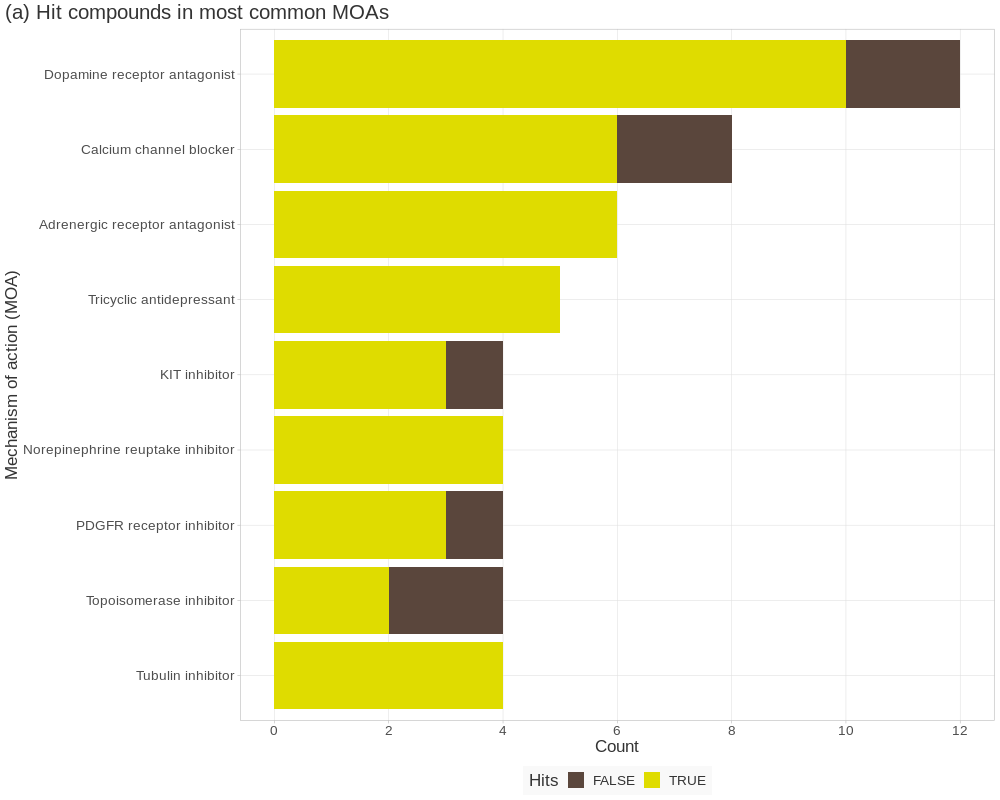

RObject{VecSxp}


In [73]:
gp = ggplot(dfMOA, aes(x = :MOA, y = :Count, fill = :Hits)) + 
     geom_bar(position="stack", stat="identity") + coord_flip() + 
     scale_y_continuous(breaks = 0:2:12) +
     theme(var"legend.position"="bottom",
           var"plot.title.position" = "plot") +
     xlab("Mechanism of action (MOA)") + 
     ggtitle("(a) Hit compounds in most common MOAs") + 
     RObject(nothing)

In [74]:
ggsave("fig/HitEnrichment.pdf", gp);

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


## MOA analysis

Now we focus on MOAs with at least 2 hit compounds:

In [24]:
top_moa = names(freqHitMOA)[1][freqHitMOA .>= 2]

24-element Array{Any,1}:
 "Dopamine receptor antagonist"
 "Adrenergic receptor antagonist"
 "Calcium channel blocker"
 "Tricyclic antidepressant"
 "Norepinephrine reuptake inhibitor"
 "Tubulin inhibitor"
 "KIT inhibitor"
 "PDGFR receptor inhibitor"
 "ATM kinase inhibitor"
 "ATPase inhibitor"
 "CDK inhibitor"
 "Dopamine receptor agonist"
 "Glycogen synthase kinase inhibitor"
 "Histamine receptor agonist"
 "Microtubule inhibitor"
 "Opioid receptor agonist"
 "Protein synthesis inhibitor"
 "Ribonucleotide reductase inhibitor"
 "Selective serotonin reuptake inhibitor (SSRI)"
 "Serotonin receptor antagonist"
 "Sterol demethylase inhibitor"
 "TRPV antagonist"
 "Topoisomerase inhibitor"
 "VEGFR inhibitor"

This means focusing on the following hit compounds:

In [25]:
top_moa_hit_cpd = Set([k for (k,v) in MOA 
                         for m in v 
                         if m in top_moa]) ∩
                  RMPV.Condition[RMPV.RMPV .< 0.1]

Set{String} with 61 elements:
  "Loperamide"
  "Pergolide methanesulfonate"
  "CP466722"
  "Nicardipine hydrochloride"
  "Protriptyline hydrochloride"
  "Trimipramine maleate"
  "AMG 9810"
  "Sertaconazole nitrate"
  "Maprotiline"
  "Phenamil methanesulfonate"
  "Emetine dihydrochloride hydrate"
  "Perphenazine"
  "Roscovitine"
  "Vinblastine"
  "Carvedilol"
  "Nortriptyline hydrochloride"
  "(S)-Propranolol hydrochloride"
  "KU-55933"
  "Maprotiline hydrochloride"
  "SB 415286"
  "SR 59230A oxalate"
  "Palonosetron hydrochloride"
  "Levetiracetam"
  "Nocodazole"
  "Promazine hydrochloride"
  ⋮ 

Targets are known for all these compounds:

In [26]:
@assert all([x in keys(targets) for x in top_moa_hit_cpd])

### MOA morphological similarity

#### Load aggregated data

In [27]:
aggregatedData = CSV.read("data/aggregatedData_750cells_noSparse.csv", DataFrame);

#### Transform aggregated data - Normalization
We want to focus on variables that are changing more overall than inside of reference condition (untreated WT).

In [28]:
expAgg = Experiment(aggregatedData, description = "Median values for aggregated FOV measurements")

"Experiment with 6622/6622 entries and 390/390 features selected."

In [29]:
filters = Array{BioProfiling.AbstractSelector,1}()
# Remove metadata
strToRemove = ["Metadata_Well", "CompoundName", "Metadata_Field", "Metadata_Row", "Metadata_Column"]
push!(filters, NameSelector(x -> !any(occursin.(strToRemove, String(x)))))
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"))
select_features!(expAgg, filters)

In [30]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [31]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selected_features] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
    expTransformed.data[i:i, expTransformed.selected_features] ./= 
        mapcols(mad, ndf[(c1 .& (c2 .| c3)),:]) 
end

select_features!(expTransformed,
                 Selector(x -> !any(isinf.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the DMSO images)"));

decorrelate_by_mad!(expTransformed);

In [32]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y)) 
# We now only keep hit compounds
filter_entries!(expTransformed, Filter(top_moa_hit_cpd, :CompoundName, compare = compare_in));

In [33]:
expTransformed

"Experiment with 1113/6622 entries and 199/390 features selected."

### Dimensionality reduction

In [34]:
using Distances
Random.seed!(3895)
umTPM = umap(expTransformed, 4, metric = CosineDist(), min_dist = 2)
umTPM = convert(DataFrame, umTPM')
rename!(umTPM, Symbol.("UMAP" .* string.(1:ncol(umTPM))));

In [35]:
umTPM.Compound = expTransformed.data.CompoundName[expTransformed.selected_entries]
umTPM.MOA = [[y for y in MOA[x] if y in top_moa] for x in umTPM.Compound]
umTPM.MOA2 = CategoricalArray(string.(umTPM.MOA));

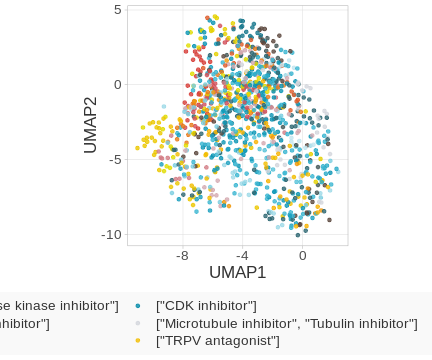

RObject{VecSxp}


In [36]:
ggplot(umTPM, aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :MOA2), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

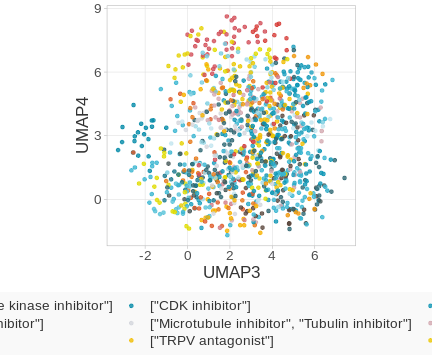

RObject{VecSxp}


In [37]:
ggplot(umTPM, aes(:UMAP3, :UMAP4)) + 
    geom_point(aes(color = :MOA2), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

In [38]:
expUMAP = Experiment(umTPM, description = "UMAP projection of profiling data")
filters = Array{BioProfiling.AbstractReduce,1}()
# Remove (categorical) compound column from analysis
push!(filters, NameSelector(x -> x != "Compound"))
push!(filters, NameSelector(x -> x != "MOA"))
push!(filters, NameSelector(x -> x != "MOA2"))
# Apply filters
filter!(expUMAP, filters)
expUMAP

"Experiment with 1113/1113 entries and 4/7 features selected."

In [39]:
pairwise_hellinger = DataFrame([(x, y) for x in levels(top_moa_hit_cpd) for y in levels(top_moa_hit_cpd) if x != y]);
exp_cpd = expTransformed.data[expTransformed.selected_entries, :CompoundName]
pairwise_hellinger.distance = [distance_robust_hellinger(getdata(expUMAP), 
                                                         exp_cpd.==x, 
                                                         exp_cpd.==y) 
                               for (x,y) in eachrow(pairwise_hellinger)]
rename!(pairwise_hellinger, ["X", "Y", "distance"]);

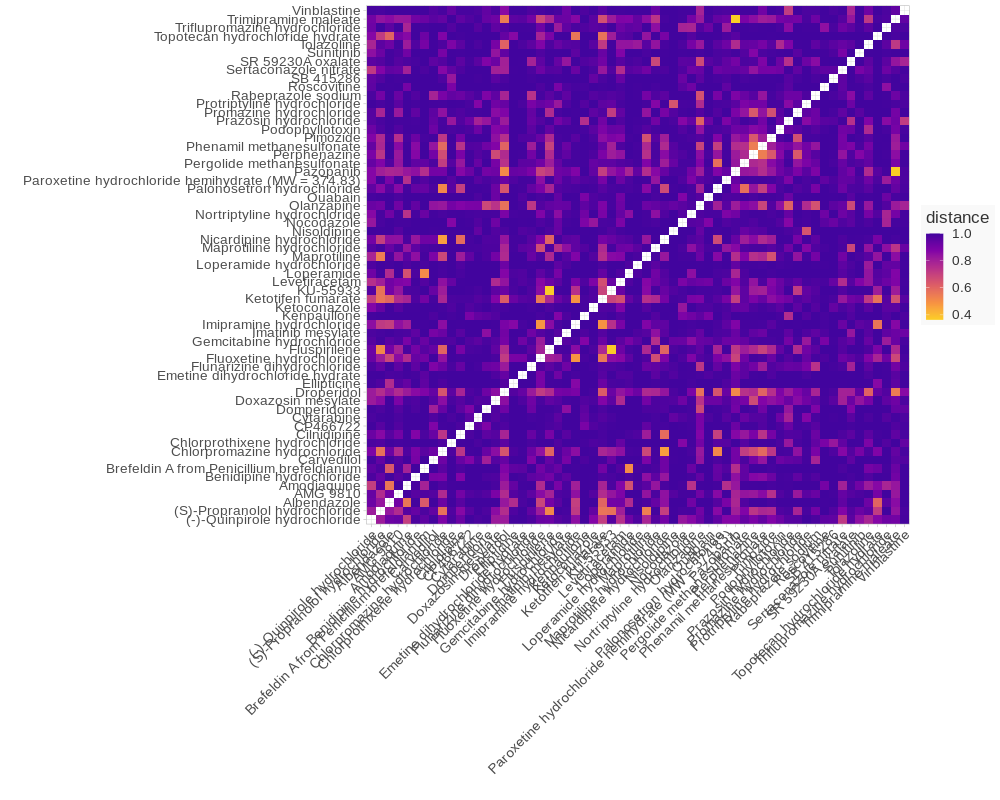

RObject{VecSxp}


In [40]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
ggplot(pairwise_hellinger, aes(x = :X, y = :Y, fill = :distance)) +
    geom_tile() +
    xlab("") +
    ylab("") + 
    theme(var"axis.text.x" = element_text(angle = 45, hjust = 1)) +
    RObject(nothing)

In [41]:
top_hits_per_moa = Dict(moa => [x for x in top_moa_hit_cpd if moa in MOA[x]] for moa in top_moa)

Dict{String,Array{String,1}} with 24 entries:
  "Ribonucleotide reductas… => ["Gemcitabine hydrochloride", "Cytarabine"]
  "Calcium channel blocker" => ["Nicardipine hydrochloride", "Levetiracetam", "…
  "Microtubule inhibitor"   => ["Vinblastine", "Podophyllotoxin"]
  "Histamine receptor agon… => ["Amodiaquine", "Ketotifen fumarate"]
  "Dopamine receptor agoni… => ["Pergolide methanesulfonate", "(-)-Quinpirole h…
  "Tubulin inhibitor"       => ["Vinblastine", "Nocodazole", "Albendazole", "Po…
  "ATPase inhibitor"        => ["Rabeprazole sodium", "Ouabain"]
  "Protein synthesis inhib… => ["Emetine dihydrochloride hydrate", "Brefeldin A…
  "PDGFR receptor inhibito… => ["Imatinib mesylate", "Pazopanib", "Sunitinib"]
  "Tricyclic antidepressan… => ["Protriptyline hydrochloride", "Trimipramine ma…
  "CDK inhibitor"           => ["Roscovitine", "Kenpaullone"]
  "Opioid receptor agonist" => ["Loperamide", "Loperamide hydrochloride"]
  "VEGFR inhibitor"         => ["Pazopanib", "Sunitinib"]
 

In [42]:
moa_pairwise_hellinger = DataFrame([(x, y) for x in top_moa 
                                           for y in top_moa if x != y]);
moa_pairwise_hellinger.distance = [mean(pairwise_hellinger[
                                        [x in top_hits_per_moa[moa1] for x in pairwise_hellinger.X] .&
                                        [x in top_hits_per_moa[moa2] for x in pairwise_hellinger.Y],
                                        :distance])
                                   for (moa1,moa2) in eachrow(moa_pairwise_hellinger)]
rename!(moa_pairwise_hellinger, ["X", "Y", "distance"]);

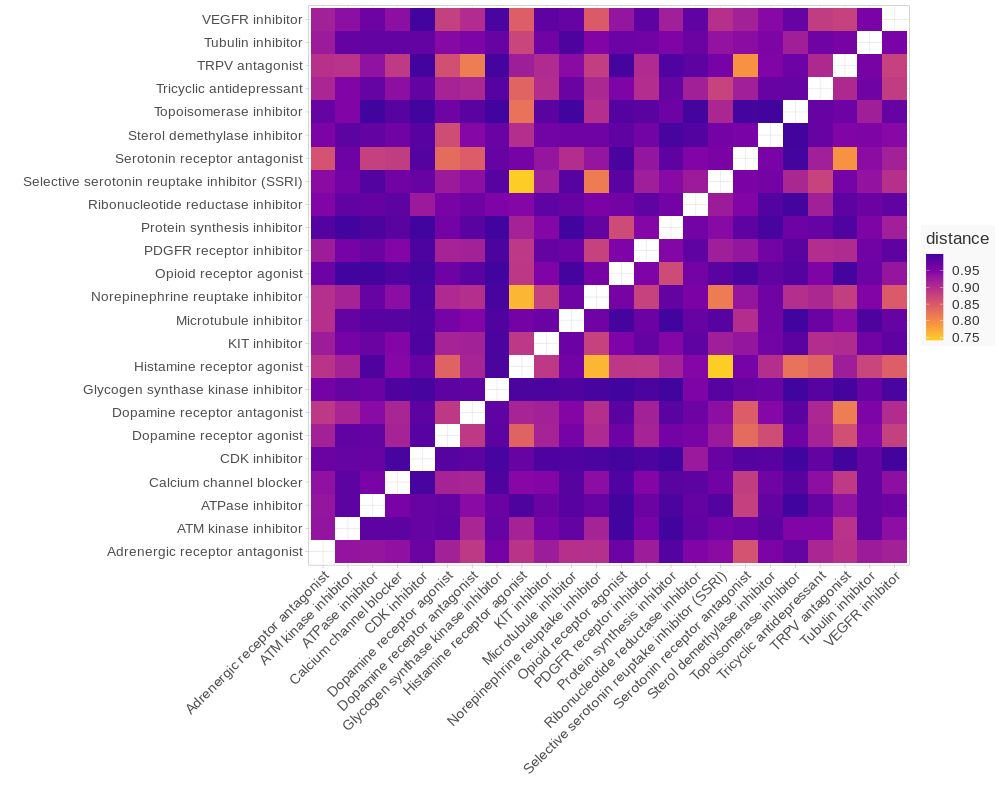

RObject{VecSxp}


In [43]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
ggplot(moa_pairwise_hellinger, aes(x = :X, y = :Y, fill = :distance)) +
    geom_tile() +
    xlab("") +
    ylab("") + 
    theme(var"axis.text.x" = element_text(angle = 45, hjust = 1)) +
    RObject(nothing)

### MOA target PPI similarity

#### Load PPI from HIPPIE database

In [44]:
# Fetch last version of HIPPIE database (2.2 when writing this notebook)
hippie = HTTP.get("http://cbdm-01.zdv.uni-mainz.de/~mschaefer/hippie/hippie_current.txt")
hippie = CSV.read(hippie.body, DataFrame, header = false)
rename!(hippie, ["Uniprot1", "Entrez1", "Uniprot2", "Entrez2", "Confidence", "Experiments"])

,Uniprot1,Entrez1,Uniprot2,Entrez2,Confidence,Experiments
,String?,Int64,String?,Int64,Float64,String?
1,AL1A1_HUMAN,216,AL1A1_HUMAN,216,0.76,"experiments:in vivo,Two-hybrid;pmids:12081471,16189514,25416956;sources:HPRD,BioGRID,IntAct,MINT,I2D,Rual05"
2,ITA7_HUMAN,3679,ACHA_HUMAN,1134,0.73,"experiments:in vivo,Affinity Capture-Western,affinity chromatography technology;pmids:10910772;sources:HPRD,BioGRID,I2D"
3,NEB1_HUMAN,55607,ACTG_HUMAN,71,0.65,"experiments:in vitro,in vivo;pmids:9362513,12052877;sources:HPRD"
4,SRGN_HUMAN,5552,CD44_HUMAN,960,0.63,"experiments:in vivo;pmids:9334256,16189514,16713569;sources:HPRD,I2D,Rual05,Lim06"
5,GRB7_HUMAN,2886,ERBB2_HUMAN,2064,0.9,"experiments:in vitro,in vivo,Reconstituted Complex,protein array,affinity chromatography technology,nuclear magnetic resonance,x-ray crystallography,competition binding,pull down;pmids:9079677,16273093,12975581,12061724,17875712;sources:HPRD,BioGRID,MINT,I2D,IntAct"
6,PAK1_HUMAN,5058,ERBB2_HUMAN,2064,0.73,"experiments:in vivo,Affinity Capture-Western,affinity chromatography technology;pmids:9774445;sources:HPRD,BioGRID,I2D,STRING"
7,DLG4_HUMAN,1742,ERBB2_HUMAN,2064,0.87,"experiments:in vivo,Two-hybrid,Affinity Capture-Western,Co-fractionation,affinity chromatography technology;pmids:10839362,16713569;sources:HPRD,BioGRID,I2D,Lim06"
8,P85B_HUMAN,5296,ERBB2_HUMAN,2064,0.89,"experiments:in vivo,Reconstituted Complex,Biochemical Activity,protein array,pull down,enzymatic study;pmids:1334406,16273093,16729043;sources:HPRD,BioGRID,MINT,I2D,IntAct,KEGG,STRING"
9,PTN18_HUMAN,26469,ERBB2_HUMAN,2064,0.88,"experiments:in vitro,pull down,anti tag coimmunoprecipitation,x-ray crystallography,phosphatase assay;pmids:14660651,25081058;sources:HPRD,I2D,IntAct"


HIPPIE's Q&A section suggests:  
```medium confidence (0.63 - second quartile of the HIPPIE score distribution) or high confidence (0.73 - third quartile)```

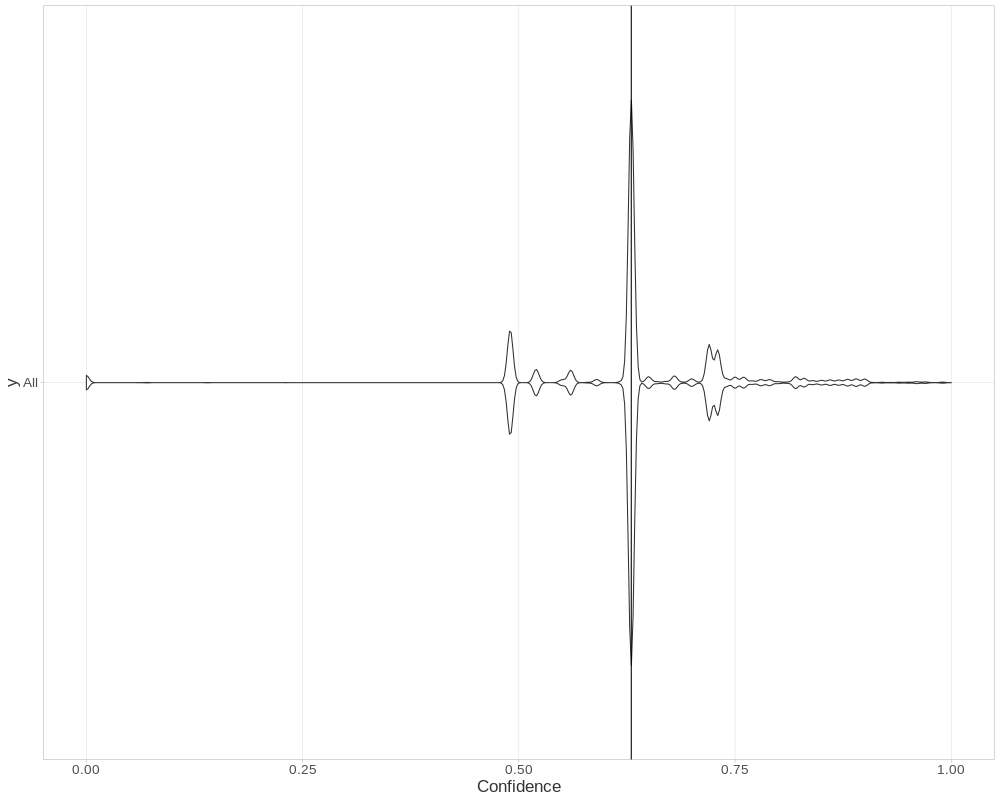

RObject{VecSxp}


In [45]:
ggplot(hippie, aes(x = :Confidence, y = "All")) +
    geom_violin() +
    geom_vline(xintercept = 0.63)

In [46]:
hippie = hippie[hippie.Confidence .>= 0.63, 1:4]
hippie = hippie[.!(ismissing.(hippie.Entrez1)), :]
hippie = hippie[.!(ismissing.(hippie.Entrez2)), :]

,Uniprot1,Entrez1,Uniprot2,Entrez2
,String?,Int64,String?,Int64
1,AL1A1_HUMAN,216,AL1A1_HUMAN,216
2,ITA7_HUMAN,3679,ACHA_HUMAN,1134
3,NEB1_HUMAN,55607,ACTG_HUMAN,71
4,SRGN_HUMAN,5552,CD44_HUMAN,960
5,GRB7_HUMAN,2886,ERBB2_HUMAN,2064
6,PAK1_HUMAN,5058,ERBB2_HUMAN,2064
7,DLG4_HUMAN,1742,ERBB2_HUMAN,2064
8,P85B_HUMAN,5296,ERBB2_HUMAN,2064
9,PTN18_HUMAN,26469,ERBB2_HUMAN,2064


#### Construct PPI network

In [47]:
allgenes = hippie.Entrez1 ∪ hippie.Entrez2
gene_to_ID = Dict(v => i  for (i,v) in enumerate(allgenes))
ID_to_gene = Dict(i => v  for (i,v) in enumerate(allgenes));

In [48]:
# Duplicated links and self-edges are discarded
G = SimpleGraph(length(allgenes))
map(x -> add_edge!(G, Tuple(x)), eachrow(map(x -> gene_to_ID[x], Array(hippie[:, [:Entrez1, :Entrez2]]))));

In [49]:
function symbol_to_entrez_mygeneinfo(s::AbstractString)
    prefix = "http://mygene.info/v3/query?q=symbol:"
    suffix = "&species=human&fields=entrez"
    rq = prefix*s*suffix
    resRq = HTTP.get(rq)
    entrezRQ = JSON.Parser.parse(String(resRq.body))
    if entrezRQ["total"] > 0
        return(entrezRQ["hits"][1]["_id"])
    else
        return(NaN)
    end
end

symbol_to_entrez_mygeneinfo (generic function with 1 method)

In [50]:
alltargets = unique(collect(Iterators.flatten(values(targets))))
alltargets_entrez = symbol_to_entrez_mygeneinfo.(alltargets);

In [51]:
alltargets_dict = Dict(k => v for (k,v) in zip(alltargets, alltargets_entrez))
# Manually correct missing Entrez ID
alltargets_dict["MT-ND1"] = "4535";

To quantify closeness of drug modules, we use the $s_{AB}$ score from Menche et al. (Science, 2015) defined as follows:
$s_{AB} = <d_{AB}> - \frac{<d_{AA}>+<d_{BB}>}{2}$

In [52]:
moa_targets = Dict(k => unique(vcat([targets[cpd] for cpd in v]...)) 
                   for (k,v) in top_hits_per_moa)

Dict{String,Array{Any,1}} with 24 entries:
  "Glycogen synthase kinas… => Any["GSK3B", "GSK3A", "RPS6KB1", "CDK1", "CDK5",…
  "Calcium channel blocker" => Any["CACNA1C", "ADORA3", "ADRA1A", "ADRA1B", "AD…
  "Microtubule inhibitor"   => Any["TUBB", "JUN", "TUBA1A", "TUBD1", "TUBE1", "…
  "Histamine receptor agon… => Any["HNMT", "CYP2C8", "HRH1", "PDE4A", "PDE4B", …
  "Dopamine receptor agoni… => Any["DRD1", "DRD2", "ADRA2A", "ADRA2B", "ADRA2C"…
  "Tubulin inhibitor"       => Any["TUBB", "JUN", "TUBA1A", "TUBD1", "TUBE1", "…
  "ATPase inhibitor"        => Any["ATP4A", "CYP2C19", "ATP1A1", "ATP1A2", "ATP…
  "Protein synthesis inhib… => Any["RPS2", "ARF1", "ARFGEF1", "ARFGEF2", "CYTH2…
  "PDGFR receptor inhibito… => Any["ABL1", "KIT", "PDGFRA", "BCR", "CSF1R", "PD…
  "Tricyclic antidepressan… => Any["SLC6A2", "SLC6A4", "SLC6A3", "ADRA1A", "ADR…
  "CDK inhibitor"           => Any["CDK2", "CDK9", "CDK7", "CDK1", "CDK5", "GSK…
  "Opioid receptor agonist" => Any["OPRM1", "OPRD1", "CACNA1A", "C

In [53]:
shortest_distance_table = Dict{Tuple,Float64}()
for x in alltargets_entrez
    for y in alltargets_entrez
        if isa(x, String) & isa(y, String) 
        if (x <= y) & (parse(Int, x) in allgenes) & (parse(Int, y) in allgenes)
            a = gene_to_ID[parse(Int,x)]
            b = gene_to_ID[parse(Int,y)]
            shortest_distance_table[(x,y)] = length(a_star(G, a,b))
            shortest_distance_table[(y,x)] = shortest_distance_table[(x,y)]
        end
        end
    end
end

In [54]:
save("data/shortest_distance_table.jld", "data", shortest_distance_table)

In [55]:
shortest_distance_table = load("data/shortest_distance_table.jld")["data"]

Dict{Tuple,Float64} with 112225 entries:
  ("11188", "2260")  => 2.0
  ("50632", "293")   => 3.0
  ("6240", "1555")   => 3.0
  ("3357", "240")    => 3.0
  ("775", "207")     => 2.0
  ("1719", "776")    => 4.0
  ("4882", "10019")  => 4.0
  ("3783", "6300")   => 3.0
  ("3832", "2932")   => 2.0
  ("1576", "6571")   => 3.0
  ("7454", "1787")   => 3.0
  ("153", "2100")    => 2.0
  ("55107", "10564") => 3.0
  ("43", "3269")     => 3.0
  ("6261", "1719")   => 2.0
  ("7846", "6340")   => 3.0
  ("136", "117155")  => 4.0
  ("291", "6338")    => 3.0
  ("8854", "1813")   => 3.0
  ("478", "6340")    => 2.0
  ("3767", "1571")   => 4.0
  ("6446", "147")    => 2.0
  ("2562", "108")    => 4.0
  ("4306", "472")    => 2.0
  ("55879", "5604")  => 3.0
  ⋮                  => ⋮

If you already saved the output:
```shortest_distance_table = load("data/shortest_distance_table.jld")["data"]```

In [56]:
function moa_mean_shortest_distance(cpd1::AbstractString, cpd2::AbstractString)
    # Note that some target genes are not present in the PPI network
    entrez1 = [gene_to_ID[parse(Int, alltargets_dict[x])] for x in moa_targets[cpd1]
                                if parse(Int, alltargets_dict[x]) in allgenes]
    entrez2 = [gene_to_ID[parse(Int, alltargets_dict[x])] for x in moa_targets[cpd2]
                                if parse(Int, alltargets_dict[x]) in allgenes]
    if isempty(entrez1) | isempty(entrez2)
        return(NaN)
    else
        return(mean([length(a_star(G, x, y)) for x in entrez1 for y in entrez2]))
    end
end

moa_mean_shortest_distance (generic function with 1 method)

In [57]:
function moa_sAB(cpd1::AbstractString, cpd2::AbstractString)
    entrez1 = [alltargets_dict[x] for x in moa_targets[cpd1]
                                if parse(Int, alltargets_dict[x]) in allgenes]
    entrez2 = [alltargets_dict[x] for x in moa_targets[cpd2]
                                if parse(Int, alltargets_dict[x]) in allgenes]
    
        
    dAB = mean(vcat(
            [minimum([shortest_distance_table[(e,f)] for f in entrez2])
            for e in entrez1],
            [minimum([shortest_distance_table[(e,f)] for f in entrez1])
            for e in entrez2]
        ))
    dAA = mean([minimum([shortest_distance_table[(e,f)] for f in entrez1 if e != f])
        for e in entrez1])
    dBB = mean([minimum([shortest_distance_table[(e,f)] for f in entrez2 if e != f])
        for e in entrez2])
    return(dAB - ((dAA + dBB)/2))
end

moa_sAB (generic function with 1 method)

In [58]:
moa_pairwise_sAB = DataFrame([(x, y) 
                              for x in keys(moa_targets) 
                              for y in keys(moa_targets) 
                              if lowercase(x) < lowercase(y)])
moa_pairwise_sAB.sAB = [moa_sAB(x, y) for (x,y) in eachrow(moa_pairwise_sAB)]
rename!(moa_pairwise_sAB, ["X", "Y", "s_AB"]);

Export results:
```
save("data/sab_moa.jld", "data", moa_pairwise_sAB)
```

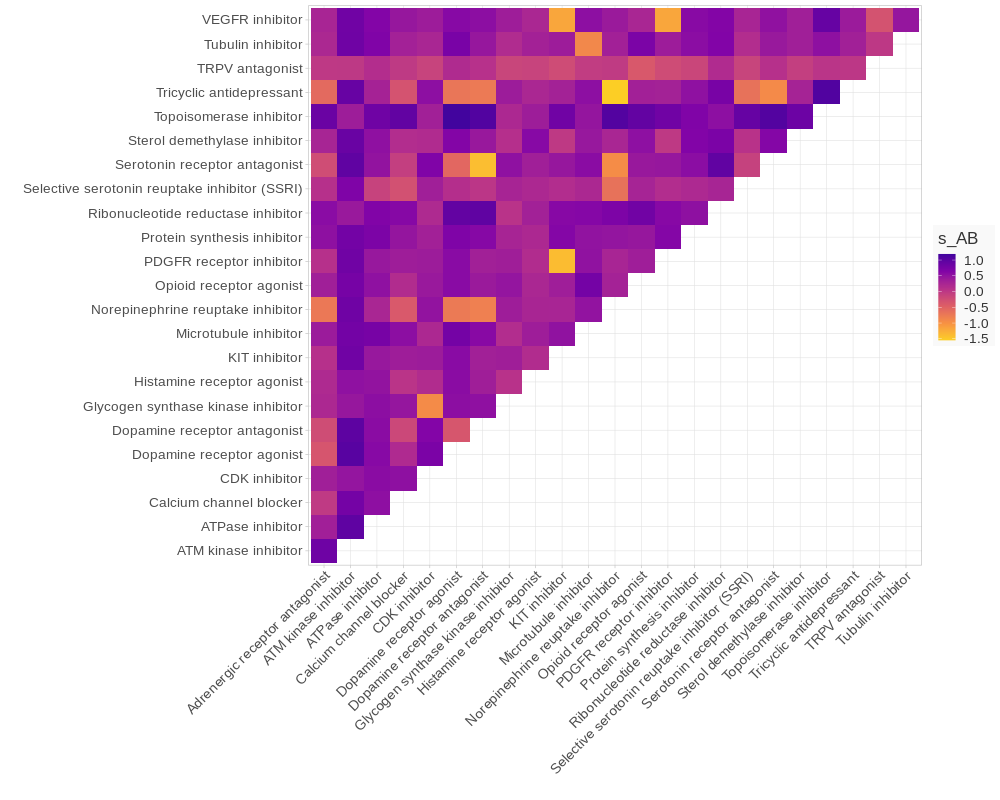

RObject{VecSxp}


In [59]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
ggplot(moa_pairwise_sAB, aes(x = :X, y = :Y, fill = :s_AB)) +
    geom_tile() +
    xlab("") +
    ylab("") + 
    theme(var"axis.text.x" = element_text(angle = 45, hjust = 1)) +
    RObject(nothing)

## Visualize both distance types

In [60]:
moa_pairwise_concatenation = DataFrame([(x, y) for x in keys(moa_targets) 
                                               for y in keys(moa_targets)
                                               if x != y])
rename!(moa_pairwise_concatenation, [:X, :Y])
moa_pairwise_concatenation.sAB = [lowercase(x) < lowercase(y) ? 
                                         moa_pairwise_sAB.s_AB[
                                            (moa_pairwise_sAB.X .== x).&
                                            (moa_pairwise_sAB.Y .== y)][1] : NaN 
                                    for (x,y) in eachrow(moa_pairwise_concatenation)]
moa_pairwise_concatenation.hellinger =  [lowercase(x) > lowercase(y) ? 
                                         moa_pairwise_hellinger.distance[
                                            (moa_pairwise_hellinger.X .== x).&
                                            (moa_pairwise_hellinger.Y .== y)][1] : NaN 
                                    for (x,y) in eachrow(moa_pairwise_concatenation)];

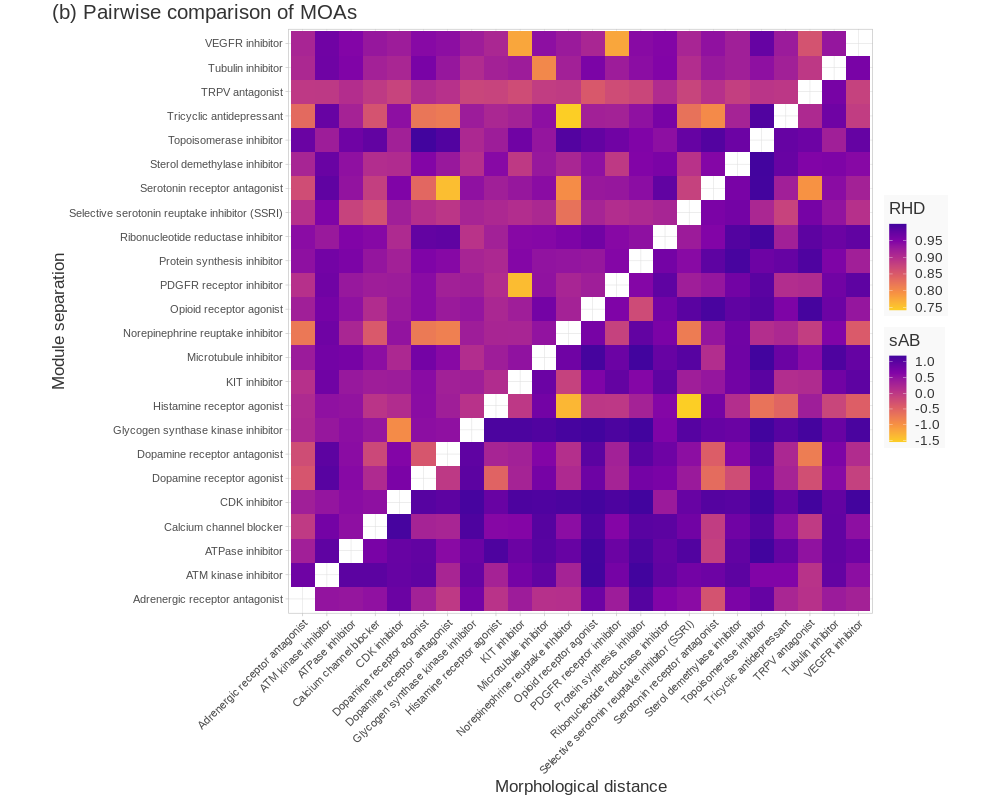

RObject{VecSxp}


In [75]:
gp = ggplot(moa_pairwise_concatenation, aes(x = :X, y = :Y)) +
    geom_tile(aes(fill = :sAB), 
              data = moa_pairwise_concatenation[.!isnan.(moa_pairwise_concatenation.sAB),:]) +
    new_scale_fill() +
    geom_tile(aes(fill = :hellinger), 
              data = moa_pairwise_concatenation[.!isnan.(moa_pairwise_concatenation.hellinger),:]) +
    xlab("Morphological distance") +
    ylab("Module separation") + 
    coord_fixed() +
    labs(fill = "RHD") + 
    theme(var"legend.position"="right",
          var"axis.text.y" = element_text(size = 11),
          var"plot.title.position" = "plot",
          var"axis.text.x" = element_text(angle = 45, hjust = 1, size = 11)) +
    ggtitle("(b) Pairwise comparison of MOAs") + 
    RObject(nothing)
gp

In [76]:
ggsave("fig/DistComparison.pdf", width = 9, gp);

┌ Warning: RCall.jl: Saving 9 x 7 in image
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160


In [63]:
moa_pairwise_comparison = innerjoin(moa_pairwise_sAB, moa_pairwise_hellinger, on = [:X, :Y]);

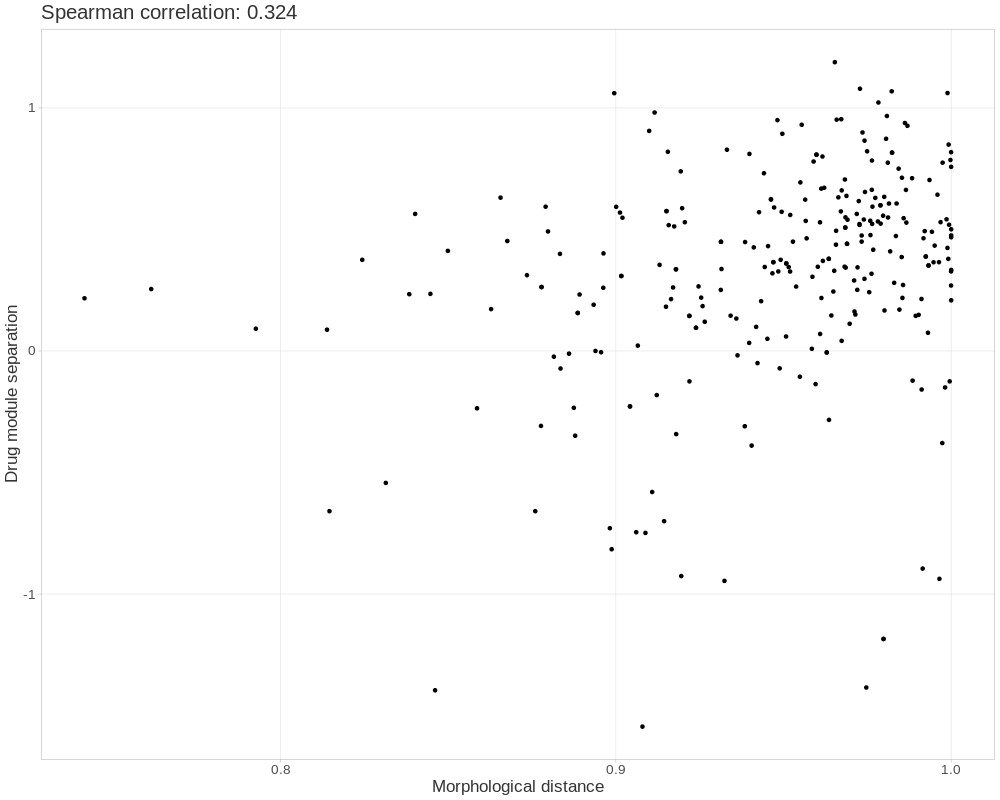

RObject{VecSxp}


In [64]:
ggplot(moa_pairwise_comparison, aes(x = :distance, y = :s_AB)) +
    geom_point() +
    ylab("Drug module separation") +
    xlab("Morphological distance") +
    ggtitle("Spearman correlation: " * 
        string(round(
        corspearman(moa_pairwise_comparison.s_AB, moa_pairwise_comparison.distance), digits = 3))) + 
    RObject(nothing)

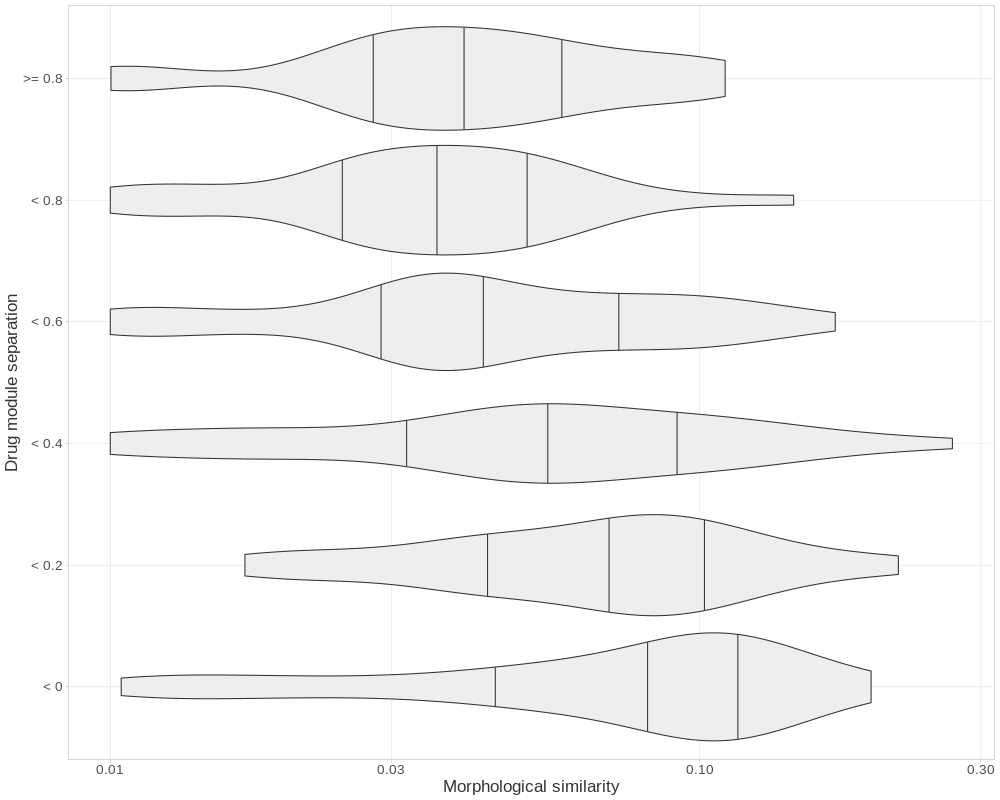

RObject{VecSxp}


In [65]:
moa_pairwise_comparison.modules = [x < 0.0 ? "< 0" : 
                                   x < 0.2 ? "< 0.2" : 
                                   x < 0.4 ? "< 0.4" : 
                                   x < 0.6 ? "< 0.6" : 
                                   x < 0.8 ? "< 0.8" : ">= 0.8" for x in moa_pairwise_comparison.s_AB]
moa_pairwise_comparison.closeness = 1.01 .- moa_pairwise_comparison.distance
ggplot(moa_pairwise_comparison, aes(x = :closeness, y = :modules)) +
    geom_violin(draw_quantiles = [0.25, 0.5, 0.75], fill = "#eeeeee") +
    ylab("Drug module separation") +
    xlab("Morphological similarity") +
    scale_x_log10() +
    RObject(nothing)

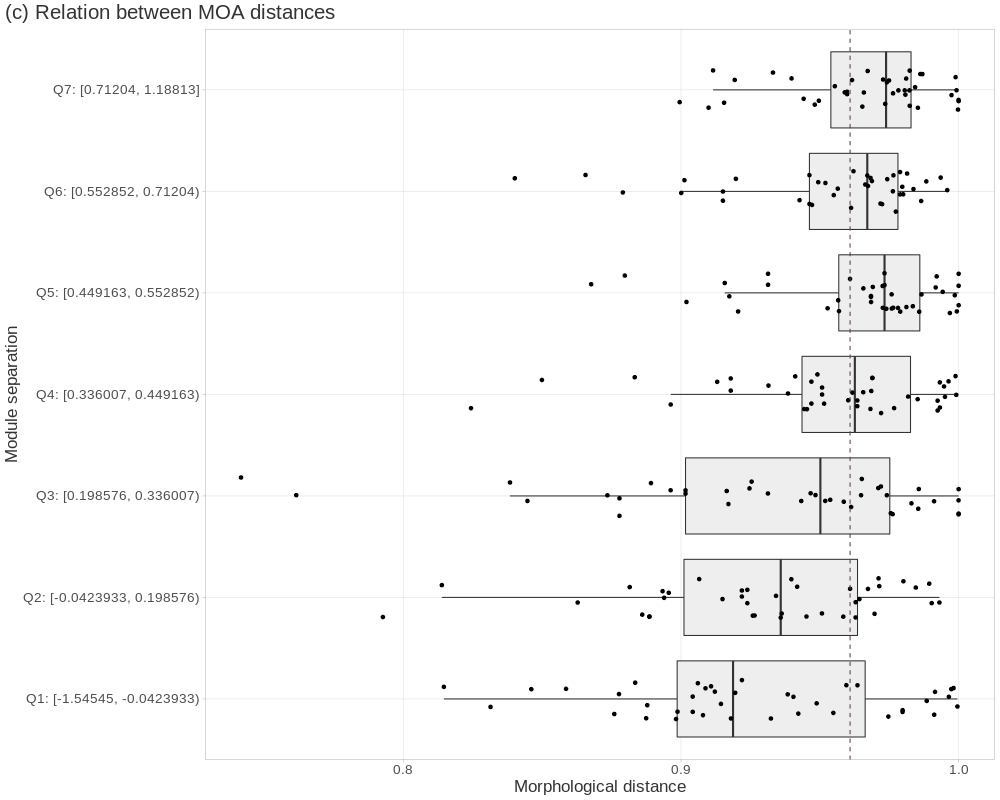

RObject{VecSxp}


In [77]:
# moa_pairwise_comparison.modules = CategoricalArray(string.(round.(moa_pairwise_comparison.s_AB) .+ 0),
#                           levels = string.(levels(round.(moa_pairwise_comparison.s_AB, digits = 1) .+ 0)))
moa_pairwise_comparison.modules = cut(moa_pairwise_comparison.s_AB, 7)
moa_pairwise_comparison.closeness = 1 .- moa_pairwise_comparison.distance
gp = ggplot(moa_pairwise_comparison, aes(x = :distance, y = :modules)) +
    geom_boxplot(fill = "#eeeeee", var"outlier.alpha" = 0) +
    geom_jitter(height = 0.2, width = 0) +
    ylab("Module separation") +
    xlab("Morphological distance") +
#     scale_x_log10() +
#     coord_flip() +
    geom_vline(xintercept = median(moa_pairwise_comparison.distance), lty = 2, color = "#5A463C") +
    ggtitle("(c) Relation between MOA distances") + 
    theme(var"plot.title.position" = "plot") +
    RObject(nothing)

In [78]:
ggsave("fig/HitStrengthComparison.pdf", gp);

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/3mHXJ/src/io.jl:160
